In [15]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Multi-Agent Research System

This notebook combines all the previous components into a single system.

Here is our overall research flow:

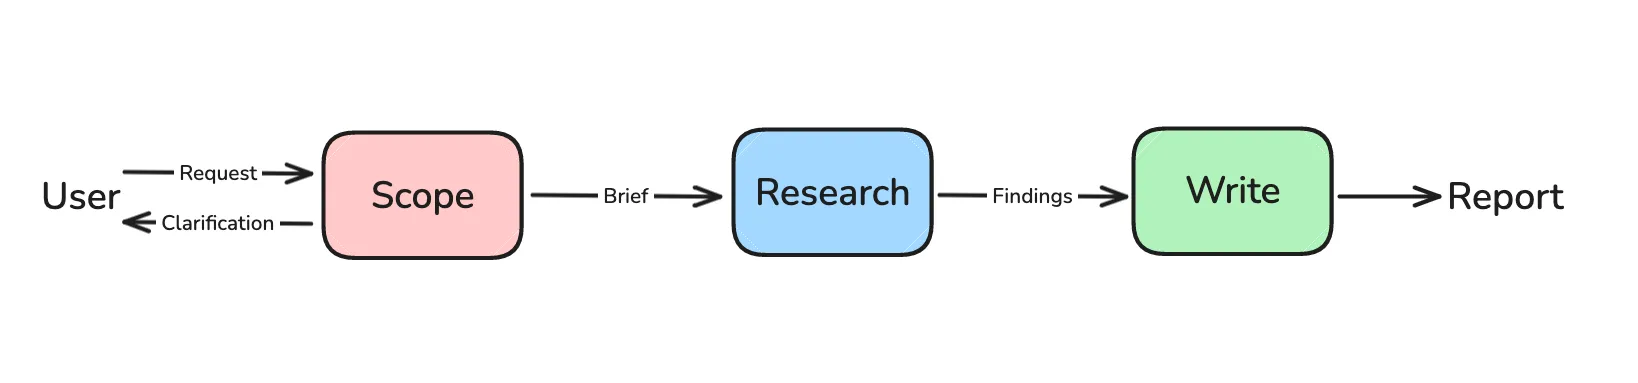

We've built research scoping and multi-agent research in previous notebooks.

Now, we'll add the final report generation step.

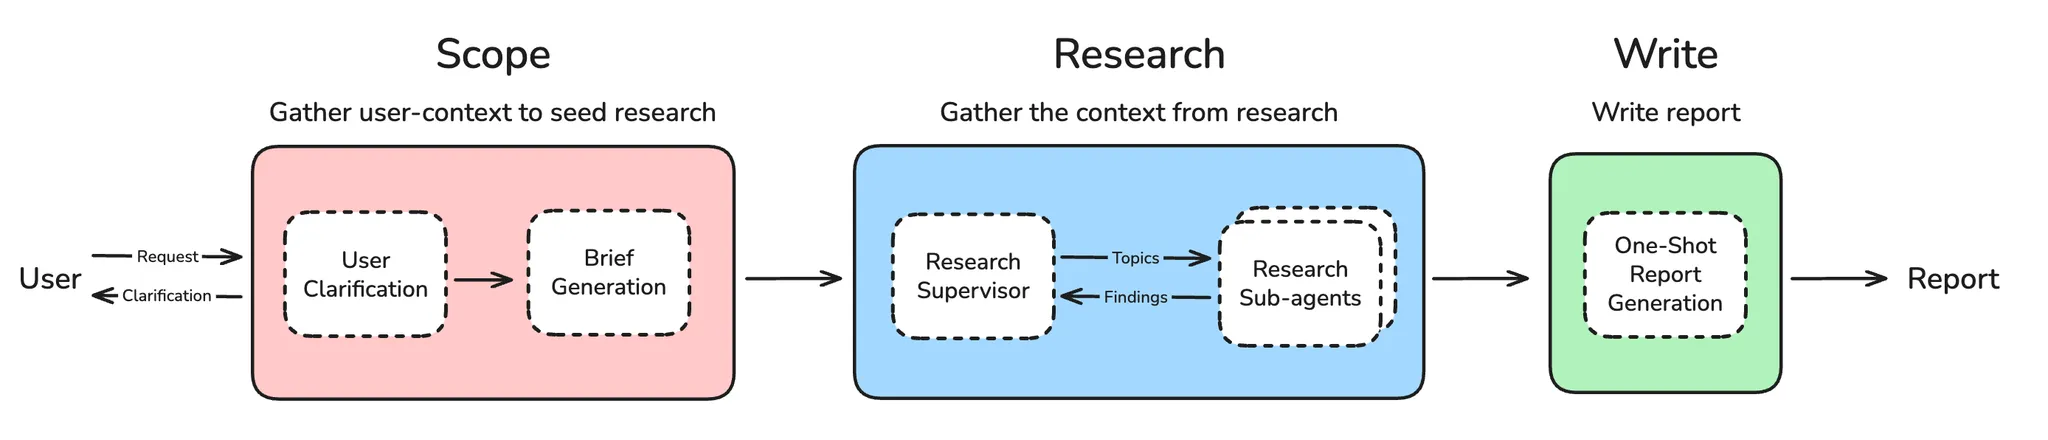

### Agent 

We simply can re-use the components we've already built.

In [16]:
%%writefile ../src/deep_research_from_scratch/research_agent_full.py

"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.utils import get_today_str
from deep_research_from_scratch.prompts import final_report_generation_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState
from deep_research_from_scratch.research_agent_scope import clarify_with_user, write_research_brief
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# ===== Config =====

from langchain.chat_models import init_chat_model
writer_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000

# ===== FINAL REPORT GENERATION =====

from deep_research_from_scratch.state_scope import AgentState

async def final_report_generation(state: AgentState):
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    """
    
    notes = state.get("notes", [])
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": ["Here is the final report: " + final_report.content],
    }

# ===== GRAPH CONSTRUCTION =====
# Build the overall workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# Compile the full workflow
agent = deep_researcher_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent_full.py


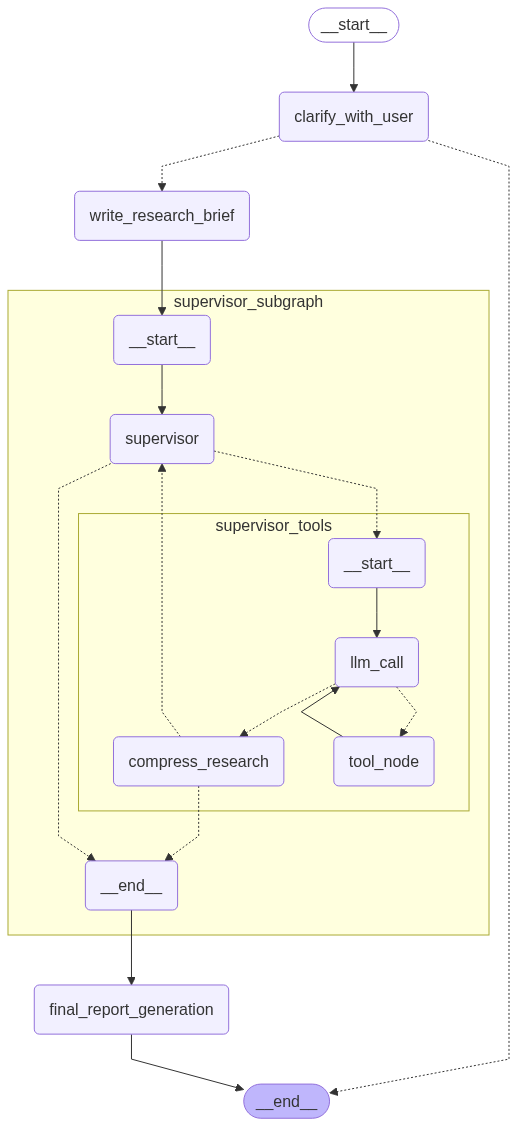

In [17]:
# Run the workflow
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

LangGraph has a default recursion limit of 25 steps to prevent infinite loops. For complex research workflows that require iterative rounds of research, this limit needs to be increased. As explained in [LangGraph's troubleshooting guide](https://langchain-ai.github.io/langgraph/troubleshooting/errors/GRAPH_RECURSION_LIMIT/), the recursion limit counts every node execution in the graph. In our multi-agent research system:

- **Single Research Agent**: May take 8-12 steps for tool calls and compression
- **Multi-Agent Supervisor**: Each sub-agent spawned adds additional steps
- **Iterative Research**: Supervisor may conduct multiple rounds of research to fill gaps
- **Full Workflow**: Includes scoping, research brief generation, supervision, and report generation

We set the recursion limit to **50** to accommodate:
- Complex research topics requiring multiple research rounds
- Parallel sub-agent execution
- Deep research with many tool calls
- Complete workflow execution from scoping to final report

This allows the supervisor to conduct iterative rounds of research when initial findings have gaps, ensuring comprehensive coverage of complex research topics.

In [3]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1", "recursion_limit": 50}}
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Compare Gemini to OpenAI Deep Research agents.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you clarify what you mean by 'OpenAI Deep Research agents'? Are you referring to a specific product,      │
│ research project, or a general class of AI agents developed by OpenAI?                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [4]:
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Yes the specific Deep Research products.")]}, config=thread)

In [5]:
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you clarify what you mean by 'OpenAI Deep Research agents'? Are you referring to a specific product,      │
│ research project, or a general class of AI agents developed by OpenAI?                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Yes the specific Deep Research products.                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for clarifying that you are referring to the specific Deep Research products from OpenAI. I           │
│ understand that you would like a comparison between Gemini and OpenAI's Deep Research agents. I will now begin  │
│ the research and prepare a comparative analysis based on the information provided.                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here is the final report: # Comprehensive Comparison: Google Gemini vs. OpenAI Deep Research Agents (2025)      │
│                                                                                                                 │
│ ## Introduction                                                                                                 │
│                                                                                                                 │
│ This report provides a detailed, balanced comparison of Google’s Gemini AI suite and OpenAI’s Deep Research     │
│ agents. Both technologies represent state-of-the-art advancements in artificial intelligence but are designed   │
│ with distinct architectures, capabilities, use cases, and integration models. This analysis examines key        │
│ aspects such as core features, intended applications, underlying technologies, performance benchmarks,          │
│ integration options, and notable strengths and weaknesses, referencing the latest information and official      │
│ documentation as of August 2025.                                                                                │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## Overview: Google Gemini                                                                                      │
│                                                                                                                 │
│ ### Core Capabilities                                                                                           │
│                                                                                                                 │
│ - **Multimodality**: Gemini supports native processing of text, images, video, audio, code, and PDF inputs, and │
│ can generate outputs in text, audio, and structured data formats. Recent iterations, such as Gemini 2.5 Deep    │
│ Think, can handle context windows exceeding 1 million tokens and output up to 192,000 tokens, enabling the      │
│ processing of vast and complex documents or media streams.                                                      │
│ - **Advanced Reasoning**: The “Deep Think” and Pro variants deploy parallel hypothesis testing and              │
│ reinforcement learning, excelling at coding, complex mathematical reasoning, multimodal understanding,          │
│ structured outputs, and function/tool calling.                                                                  │
│ - **Agentic Capabilities**: Gemini powers research agents and universal AI assistants (e.g., Project Astra,     │
│ Project Mariner), handling autonomous workflows like code debugging, real-time information retrieval, and       │
│ interactive web task completion.                                                                                │
│ - **Safety and Governance**: Gemini employs extensive safety measures, including red teaming (automated and     │
│ external), multi-tiered abuse monitoring, mitigations against sensitive domains (e.g., chemical/biological),    │
│ and oversight by Google DeepMind’s Responsibility and Safety Council. It adheres to ethical principles such as  │
│ minimization of bias and toxicity.                                                                              │
│                                                                                                                 │
│ ### Intended Use Cases                                                                                          │
│                                                        

In [6]:
from rich.markdown import Markdown
Markdown(result["final_report"])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Comprehensive Comparison: Google Gemini vs. OpenAI Deep Research Agents (2025)                  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                   Introduction                                                    

This report provides a detailed, balanced comparison of Google’s Gemini AI suite and OpenAI’s Deep Research agents.
Both technologies represent state-of-the-art advancements in artificial intelligence but are designed with distinct
architectures, capabilities, use cases, and integration models. This analysis examines key aspects such as core    
features, intended applications, underlying technologies, performance benchmarks, integration options, and notable 
strengths and weaknesses, referencing the latest information and official documentation as of August 2025.         

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                              Overview: Google Gemini                                              

                                                 Core Capabilities                                                 

 • Multimodality: Gemini supports native processing of text, images, video, audio, code, and PDF inputs, and can   
   generate outputs in text, audio, and structured data formats. Recent iterations, such as Gemini 2.5 Deep Think, 
   can handle context windows exceeding 1 million tokens and output up to 192,000 tokens, enabling the processing  
   of vast and complex documents or media streams.                                                                 
 • Advanced Reasoning: The “Deep Think” and Pro variants deploy parallel hypothesis testing and reinforcement      
   learning, excelling at coding, complex mathematical reasoning, multimodal understanding, structured outputs, and
   function/tool calling.                                                                                          
 • Agentic Capabilities: Gemini powers research agents and universal AI assistants (e.g., Project Astra, Project   
   Mariner), handling autonomous workflows like code debugging, real-time information retrieval, and interactive   
   web task completion.                                                                                            
 • Safety and Governance: Gemini employs extensive safety measures, including red teaming (automated and external),
   multi-tiered abuse monitoring, mitigations against sensitive domains (e.g., chemical/biological), and oversight 
   by Google DeepMind’s Responsibility and Safety Council. It adheres to ethical principles such as minimization of
   bias and toxicity.                                                                                              

                                                Intended Use Cases                                                 

 • Complex knowledge work (e.g., scientific research, coding assistants, market analysis)                          
 • Large-scale document analysis, summarization, and synthesis                                                     
 • Content creation across text, image, video (e.g., AI-powered design, video generation with Veo, music with      
   Lyria)                                                                                                          
 • Autonomous agents for enterprise workflows (e.g., web research, spreadsheet automation, technical support,      
   creative design)                                                                                                
 • Integration into Google products and services: Workspace (Docs, Sheets, Slides), Pixel devices, Search, Ads,    
   Chrome, and Duet AI                         

We can see the trace [here](https://smith.langchain.com/public/86ebdc25-4595-4040-be1e-a8e30052786b/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

The files we wrote with `%%writefile` to `src/deep_research_from_scratch/` during the all the notebooks create the files for our application:

```
deep_research_from_scratch/
├── src/deep_research_from_scratch/
│   ├── state.py          # State definitions
│   ├── scope_research.py # Scoping workflow
│   ├── prompts.py        # Prompt templates
│   └── ...
├── notebooks/            # Development notebooks
├── pyproject.toml        # Dependencies
└── langgraph.json        # LangGraph configuration
```

This agent has been added to the `langgraph.json` file, so you can select `research_agent_full` in the dropdown menu:

```
"research_agent_full": "./src/deep_research_from_scratch/research_agent_full.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```